In [1]:
import os
import sys

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

# Load functions for feature extraction and processing
from data_preprocessing import merge_same_direction, norm_values
from move_direction import move_abs_direction
from data_to_segments import *
from plot_helpers import *
from data_to_char import code_factors_in_chars
from patterns import find_patterns, patterns_coverage, pattern_mask

Here we want to code data into a sequence of characters, where each character refers to one or multidimentional data parameter (factor). Factors should be represented as categorical data, with limited amount of levels. Then we look for a repetitive patterns in the sequence.

The pipeline:

0. Clean the data
1. Compute metrics. Clean the data based on metrics
2. Create factors from metrics
3. Convert factors to sequences
4. Find patterns in sequences
5. Visualize
6. Compute features on data and clusterize

We already have cleaned the data and computed some metrics (features) in `prepare_data.ipynb` file. 

In [2]:
# Load the data
df = pd.read_csv('demo_data/data.csv')
print(df.shape)
df.head()

(96870, 9)


,x,y,time,user,task,move_dir,move_dir_norm,move_len,move_len_norm
0,0.38849,0.02145,0.20605,0,wiki,0.000000,0.000000,0.000000,0.000000
1,0.38830,0.04004,0.23047,0,wiki,3.151818,0.501627,0.018591,0.012910
2,0.38614,0.04428,0.26855,0,wiki,3.612759,0.574989,0.004758,0.003305
3,0.38749,0.04990,0.34180,0,wiki,2.905845,0.462480,0.005780,0.004014
4,0.38321,0.12272,0.37012,0,wiki,3.200300,0.509344,0.072946,0.050657


In [3]:
# We may want to merge movements to the same direction to cover longer paths with patterns

MERGE_SAME_DIR = False
# Merge movements to the same direction

if MERGE_SAME_DIR:
    df = merge_same_direction(df, n_directions=N_DIRECTIONS)
    
    # Recalculate move_lengths:
    # Find move direction, which can be calculated by checking the change from previous to current gaze position
    # 12 o'clock vector will be used as a staring point, from which we are going clockwise. 
    directions = move_abs_direction(df.x, df.y, invert_y=True, radians=True)
    # add one 0 value to make the vector lengths equel with the rest of the data
    df['move_dir'] = np.insert(directions, 0, 0) 
    df['move_dir_norm'] = norm_values(df['move_dir'], 0, 2 * np.pi) # normalize data from zero to one, max=2pi
    print("merged same direction", df.shape)

In [4]:
# Set up parameters for patterns

PATTERN_LEN = 4  # The length of pattern

N_DIRECTIONS = 8 # number of segments in movement directions data
N_LENGTH = 5     # number of segments in movement lenght data (choose from odd number)

We use <b>*gaze movement direction*</b> and <b>*movement length*</b> as factors. Thus, patterns will be two-dimensional. 

In [5]:
# 3. Create factors from metrics

# - Movement direction
factor_dir = data_to_segments(df['move_dir'], n_segments=N_DIRECTIONS, segment_ranges=True)

# - Length of movement (Log)
move_len_log = np.log(df['move_len'] + 1e-18)
factor_len_log = data_to_segments_quantile(move_len_log, n_segments=N_LENGTH, segment_ranges=True)

<b>Visualization</b> of data factors

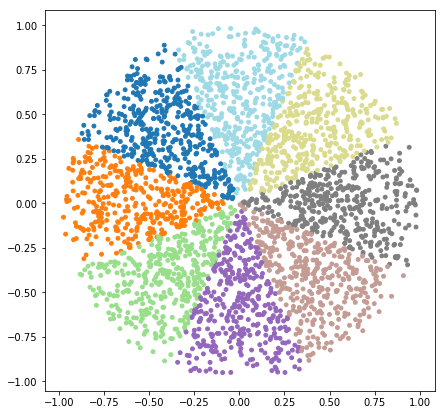

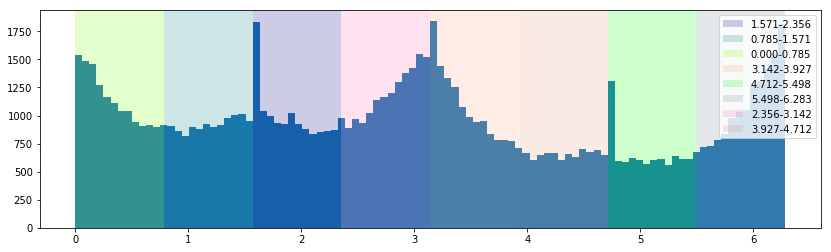

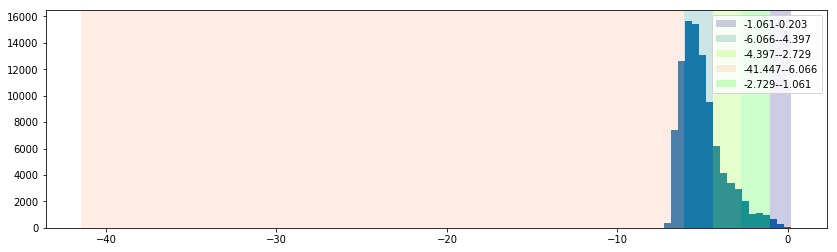

In [6]:
# Visualize segments of a screen (for directions)
p = plot_dir_segments(n_segments=N_DIRECTIONS, n=3000)
plt.savefig('imgs/direction_segments.png')
plt.show()

# Visualize segments on distribution (for direction)
p = plot_distr_segments(df['move_dir'], factor_dir)
plt.show()

# Visualize segments on distribution (for log-length)
p = plot_distr_segments(move_len_log, factor_len_log)
plt.show()

In [7]:
# 4. Convert factors to sequences
seq, codes = code_factors_in_chars([factor_dir, factor_len_log])
codes = OrderedDict(sorted(codes.items()))

for k, v in codes.items():
    print("## {} ##:  dir {:.2f}-{:.2f}, len {:.2f} - {:.2f}".format(k, v[0], v[1], v[2], v[3]))

# 5. Find patterns in sequences
patterns = find_patterns(seq, n_chars=PATTERN_LEN)
patterns_counts = patterns_coverage(patterns, len(seq))

## A ##:  dir 0.00-0.79, len -41.45 - -6.07
## B ##:  dir 0.00-0.79, len -6.07 - -4.40
## C ##:  dir 0.00-0.79, len -4.40 - -2.73
## D ##:  dir 0.00-0.79, len -2.73 - -1.06
## E ##:  dir 0.00-0.79, len -1.06 - 0.20
## F ##:  dir 0.79-1.57, len -41.45 - -6.07
## G ##:  dir 0.79-1.57, len -6.07 - -4.40
## H ##:  dir 0.79-1.57, len -4.40 - -2.73
## I ##:  dir 0.79-1.57, len -2.73 - -1.06
## J ##:  dir 0.79-1.57, len -1.06 - 0.20
## K ##:  dir 1.57-2.36, len -41.45 - -6.07
## L ##:  dir 1.57-2.36, len -6.07 - -4.40
## M ##:  dir 1.57-2.36, len -4.40 - -2.73
## N ##:  dir 1.57-2.36, len -2.73 - -1.06
## O ##:  dir 1.57-2.36, len -1.06 - 0.20
## P ##:  dir 2.36-3.14, len -41.45 - -6.07
## Q ##:  dir 2.36-3.14, len -6.07 - -4.40
## R ##:  dir 2.36-3.14, len -4.40 - -2.73
## S ##:  dir 2.36-3.14, len -2.73 - -1.06
## T ##:  dir 2.36-3.14, len -1.06 - 0.20
## U ##:  dir 3.14-3.93, len -41.45 - -6.07
## V ##:  dir 3.14-3.93, len -6.07 - -4.40
## W ##:  dir 3.14-3.93, len -4.40 - -2.73
## X ##:  

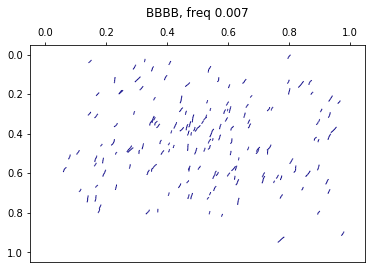

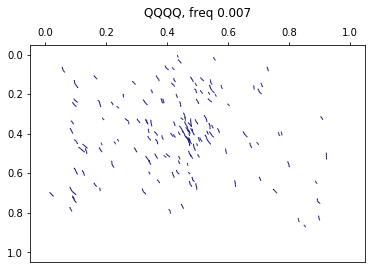

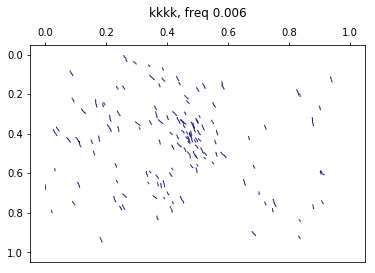

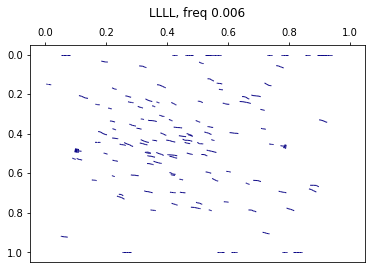

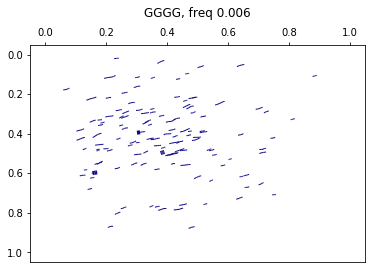

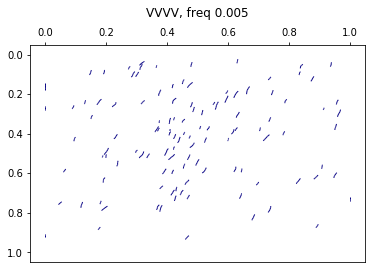

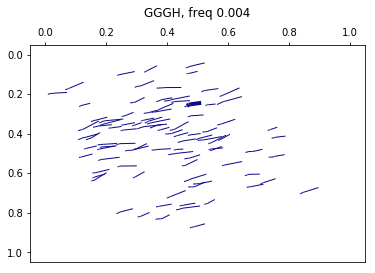

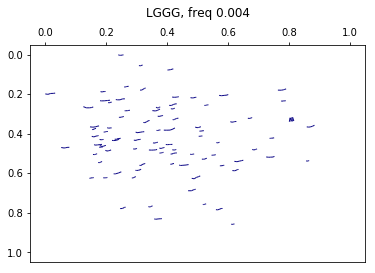

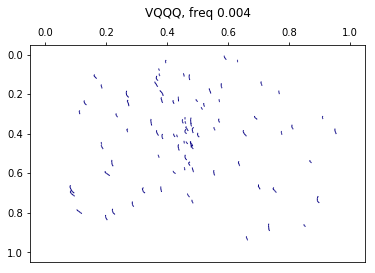

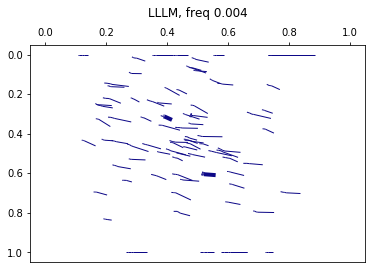

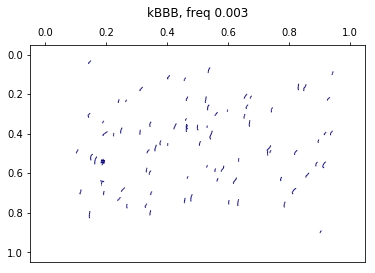

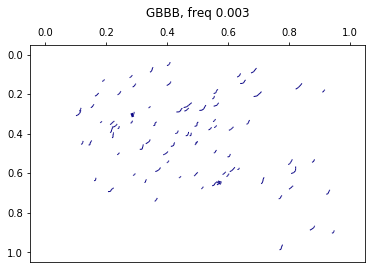

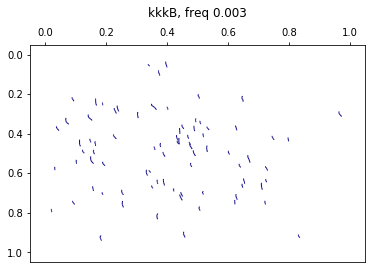

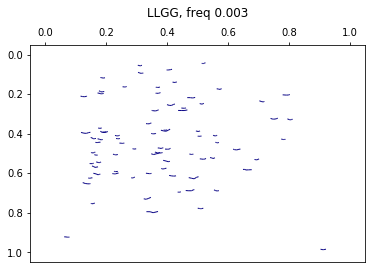

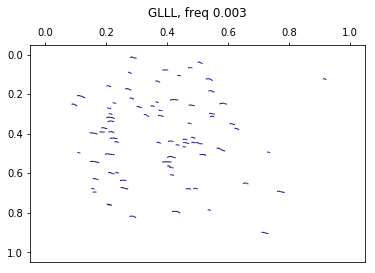

In [8]:
# 6. Visualize

for n, (pat, pat_count) in enumerate(patterns_counts[:15]):
    pat_mask = pattern_mask(seq, pat)[1:]
    pat_title = '{}, freq {:.3f}'.format(pat, pat_count)
    p = plot_path(df[['x', 'y']].values, segments_weights=pat_mask, weight_threshold=0,
              colorbar=False, figsize=(6, 4), title=pat_title)
    plt.show()

patterns:  49973


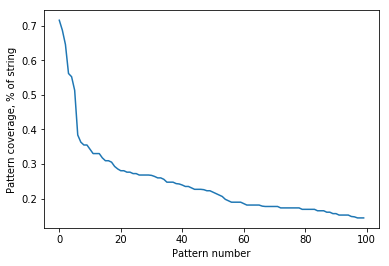

In [9]:
# Plot distribution of patterns by freq
print("patterns: ", len(patterns_counts))
plt.plot([x[1]*100 for x in patterns_counts[:100]])
plt.ylabel('Pattern coverage, % of string')
plt.xlabel('Pattern number')
plt.show()

patterns:  76785


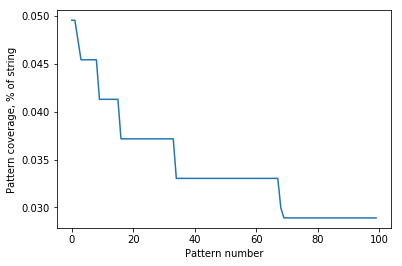

In [10]:
from random_string_test import random_seq, plot_coverage_comparison

# Random permutation test
random_s = random_seq(len(seq), from_seq=list(seq), merge_repetitions=MERGE_SAME_DIR)
random_patterns = find_patterns(random_s, n_chars=PATTERN_LEN)
random_patterns_counts = patterns_coverage(random_patterns, len(seq))

# Plot distribution of patterns by freq
print("patterns: ", len(random_patterns_counts))
plt.plot([x[1]*100 for x in random_patterns_counts[:100]])
plt.ylabel('Pattern coverage, % of string')
plt.xlabel('Pattern number')
plt.show()

80.24% of the sequence covered by top 1000 patterns
21.77% of the random sequence covered by top 1000 patterns


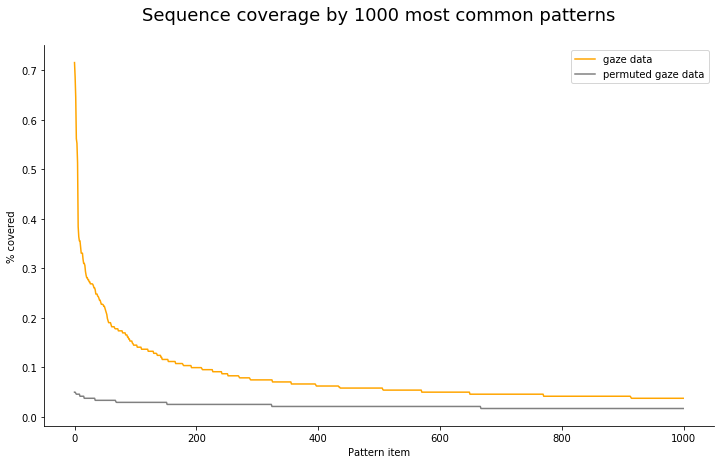

In [11]:
n = 1000
p_coverage = [x[1] for x in patterns_counts[:n]]
print("{:.2f}% of the sequence covered by top {} patterns".format(np.sum(p_coverage)*100, n))
rand_p_coverage = [x[1] for x in random_patterns_counts[:n]]
print("{:.2f}% of the random sequence covered by top {} patterns".format(np.sum(rand_p_coverage)*100, n))

p = plot_coverage_comparison(p_coverage, rand_p_coverage)
plt.show()

In [ ]:
# 7. TO DO: Compute features on data and clusterize